This notebook performs QC of regenie sumstats, liftover to hg38 and sumstats file formatting

### Setup

In [2]:
# Define the packages to be installed
packages <- c("qqman", "R.utils", 'tidyverse')

# Install packages only if they are not already installed
new_packages <- packages[!(packages %in% installed.packages()[, "Package"])]
if(length(new_packages) > 0) {
  install.packages(new_packages, dependencies = TRUE)
}

# load packages
library("dplyr")
library("stringr")
library("data.table") 
library("ggplot2")
library("tidyr")
library(qqman)
library(tidyverse)
library(R.utils)

In [5]:
## functions to load and QC regenie sumstats

regenie_df_qc <- function(df_path, N_CASES=N_CASES, N_CONTROLS=N_CONTROLS) {
    ### QCs one regenie file
    df_qc <- 
    fread(df_path) %>%
        # make P-value col
        mutate(P = 10^(-1*LOG10P)) %>%
        # make maf
        mutate(MAF = ifelse(A1FREQ > 0.5, 1 - A1FREQ, A1FREQ)) %>%
        mutate(MAF_CASES = ifelse(A1FREQ_CASES > 0.5, 1 - A1FREQ_CASES, A1FREQ_CASES)) %>%
        mutate(MAF_CONTROLS = ifelse(A1FREQ_CONTROLS > 0.5, 1 - A1FREQ_CONTROLS, A1FREQ_CONTROLS)) %>%
        # make mac 
        mutate(MAC = 2*N*MAF) %>% 
        mutate(MAC_CASES = 2*N_CASES*MAF_CASES) %>%
        mutate(MAC_CONTROLS = 2*N_CONTROLS*MAF_CONTROLS) %>% 
        # filter MAC>=5 on cases and controls
        filter(MAC_CASES >= 5 & MAC_CONTROLS >= 5) %>%
        # filter INFO >= 0.5 
        filter(INFO >= 0.5) %>%
        # select
        select(CHROM, GENPOS, ID, ALLELE0, ALLELE1, A1FREQ,A1FREQ_CASES, A1FREQ_CONTROLS, MAF, MAC, MAF_CASES, MAC_CASES, MAF_CONTROLS, MAC_CONTROLS, BETA, SE, INFO, P)
    return(df_qc)
}

read_and_qc_regenie_files <- function(df_path_list, N_CASES=N_CASES, N_CONTROLS=N_CONTROLS) {
    ### QCs all regenie files and appends in one df
    for (chrom in df_path_list) {
        df_chrom <- regenie_df_qc(chrom, N_CASES=N_CASES, N_CONTROLS=N_CONTROLS)
        if (chrom == df_path_list[1])
            df_all <- df_chrom
        else
            df_all <- bind_rows(df_all, df_chrom)
    }
    return(df_all)
}

### Dementia stratified

In [13]:
## load data

# dementia group
system('dx download -f vasilis/data/GWAS/sensitivity/dementia_stratified/step2/ukb_wb_demgroup_noqc_c*_delirium.regenie')
dem_files = list.files(pattern="ukb_wb_demgroup_noqc_c.*_delirium.regenie")
dem_qc <- read_and_qc_regenie_files(dem_files, N_CASES=2561, N_CONTROLS=5374)
dim(dem_qc)

system('dx download -f vasilis/data/GWAS/sensitivity/dementia_stratified/step2/ukb_wb_nodemgroup_noqc_c*_delirium.regenie')
nodem_files = list.files(pattern="ukb_wb_nodemgroup_noqc_c.*_delirium.regenie")
nodem_qc <- read_and_qc_regenie_files(nodem_files, N_CASES=4614, N_CONTROLS=379642)
dim(nodem_qc)

[1] 16625019       18

[1] 19767590       18

In [6]:
## APOE e4 
cat('dementia group:\n')
dem_qc %>% filter(ID %in% c('rs429358','rs7412'))
cat('\n\n')
cat('non-dementia group:\n')
nodem_qc %>% filter(ID %in% c('rs429358','rs7412'))
cat('\n\n')

dementia group:


CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,A1FREQ_CASES,A1FREQ_CONTROLS,MAF,MAC,MAF_CASES,MAC_CASES,MAF_CONTROLS,MAC_CONTROLS,BETA,SE,INFO,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,45411941,rs429358,T,C,0.3209830,0.3264350,0.3183850,0.3209830,5094.0002,0.3264350,1672.0001,0.3183850,3422.002,0.0567434,0.0377169,1,0.1324643
19,45412079,rs7412,C,T,0.0519219,0.0491995,0.0532192,0.0519219,824.0006,0.0491995,251.9998,0.0532192,572.000,-0.1133070,0.0788936,1,0.1509447




non-dementia group:


CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,A1FREQ_CASES,A1FREQ_CONTROLS,MAF,MAC,MAF_CASES,MAC_CASES,MAF_CONTROLS,MAC_CONTROLS,BETA,SE,INFO,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,45411941,rs429358,T,C,0.1528760,0.1838970,0.1524990,0.1528760,117487.04,0.1838970,1697.0015,0.1524990,115790.1,0.2422410,0.0279599,1,4.560369e-18
19,45412079,rs7412,C,T,0.0817333,0.0765063,0.0817968,0.0817333,62813.02,0.0765063,706.0001,0.0817968,62107.0,-0.0699355,0.0386230,1,7.018430e-02


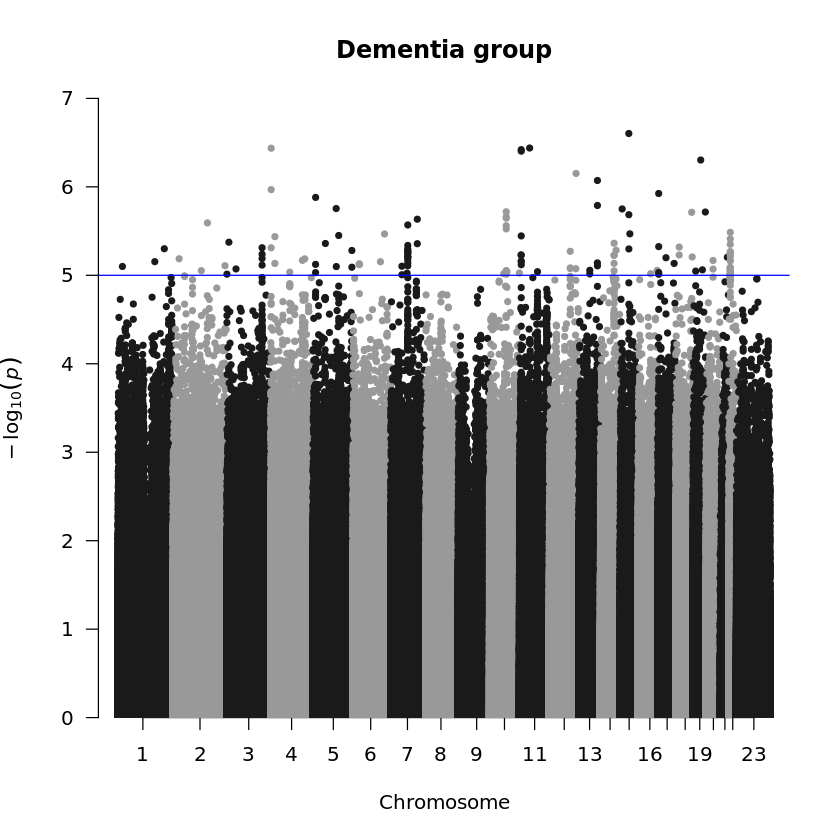

In [7]:
manhattan(dem_qc[!is.na(dem_qc$P),], chr="CHROM", bp="GENPOS", p="P", snp="ID", main='Dementia group')

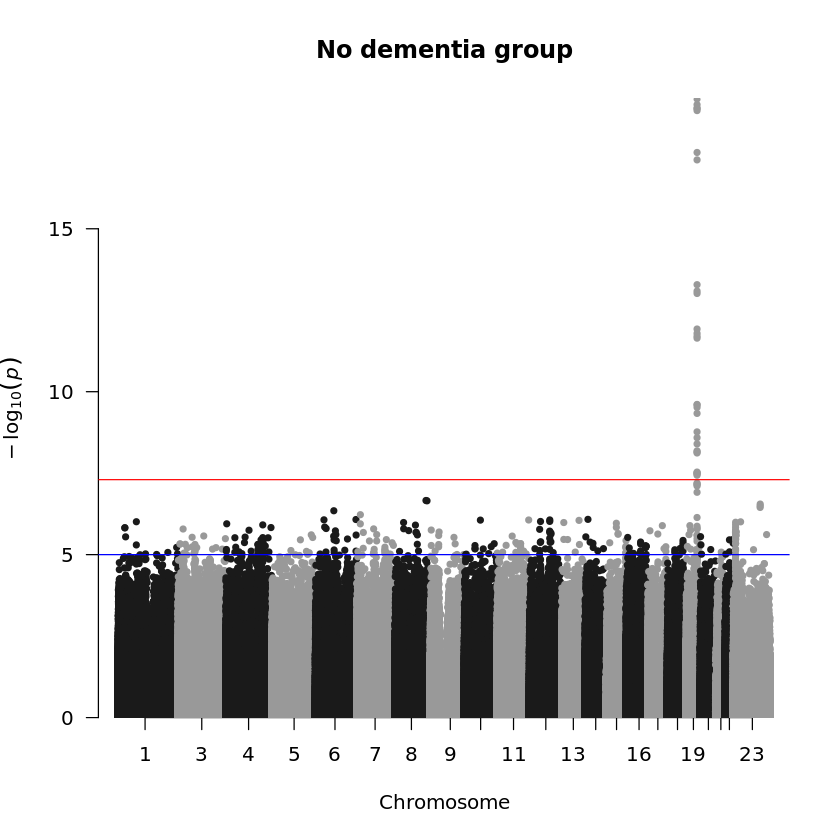

In [9]:
manhattan(nodem_qc[!is.na(nodem_qc$P),], chr="CHROM", bp="GENPOS", p="P", snp="ID", main='No dementia group')

In [14]:
## save temporary files
write.table(dem_qc, 'temp_dem_fgQC.txt', sep=" ", quote=F, row.names = F)
write.table(nodem_qc, 'temp_nodem_fgQC.txt', sep=" ", quote=F, row.names = F)

In [ ]:
## liftover

# upload liftover executable and 'hg19->hg38' chain file from local computer

# create liftover script (liftover.sh) and save it to project folder

# upload lifted sumstats: dx upload dem_hg38_final.txt --dest vasilis/data/GWAS/sensitivity/dementia_stratified/step2/hg38/

# upload liftover.sh script: dx upload liftover.sh --dest vasilis/SAK_scripts/ 

### Age stratified

In [6]:
## load & QC

# 60+ group
system('dx download -f vasilis/data/GWAS/sensitivity/age_stratified/step2/ukb_wb_age60plus_noqc_c*_delirium.regenie')
age60plus_files = list.files(pattern="ukb_wb_age60plus_noqc_c.*_delirium.regenie")
age60plus_qc <- read_and_qc_regenie_files(age60plus_files, N_CASES=6955, N_CONTROLS=335567)
dim(age60plus_qc)

# 60- group
system('dx download -f vasilis/data/GWAS/sensitivity/age_stratified/step2/ukb_wb_age60minus_noqc_c*_delirium.regenie')
age60minus_files = list.files(pattern="ukb_wb_age60minus_noqc_c.*_delirium.regenie")
age60minus_qc <- read_and_qc_regenie_files(age60minus_files, N_CASES=220, N_CONTROLS=49449)
dim(age60minus_qc)

[1] 22264414       18

[1] 9830411      18

In [7]:
## APOE e4 
cat('60+ age group:\n')
age60plus_qc %>% filter(ID %in% c('rs429358','rs7412'))
cat('\n\n')
cat('60- age group:\n')
age60minus_qc %>% filter(ID %in% c('rs429358','rs7412'))
cat('\n\n')

60+ age group:


CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,A1FREQ_CASES,A1FREQ_CONTROLS,MAF,MAC,MAF_CASES,MAC_CASES,MAF_CONTROLS,MAC_CONTROLS,BETA,SE,INFO,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,45411941,rs429358,T,C,0.1562310,0.2373830,0.1545490,0.1562310,107025.1,0.2373830,3301.9975,0.1545490,103723.09,0.531684,0.0210097,1,2.703958e-141
19,45412079,rs7412,C,T,0.0811437,0.0658519,0.0814606,0.0811437,55587.0,0.0658519,915.9999,0.0814606,54670.98,-0.230912,0.0336209,1,6.505789e-12




60- age group:


CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,A1FREQ_CASES,A1FREQ_CONTROLS,MAF,MAC,MAF_CASES,MAC_CASES,MAF_CONTROLS,MAC_CONTROLS,BETA,SE,INFO,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,45411941,rs429358,T,C,0.1565970,0.1522730,0.1566160,0.1565970,15556.033,0.1522730,67.00012,0.1566160,15489.009,-0.051541,0.135008,1,0.7026370
19,45412079,rs7412,C,T,0.0810365,0.0954545,0.0809723,0.0810365,8050.004,0.0954545,41.99998,0.0809723,8007.999,0.233377,0.182753,1,0.2015988


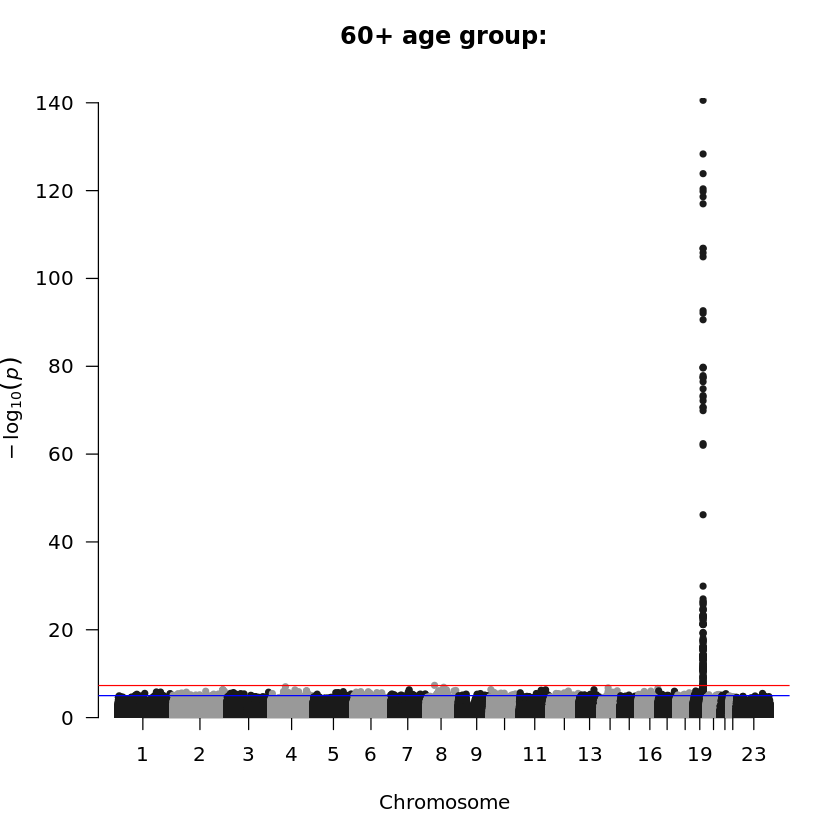

In [8]:
# 60+ group
manhattan(age60plus_qc[!is.na(age60plus_qc$P),], chr="CHROM", bp="GENPOS", p="P", snp="ID", main='60+ age group:\n')

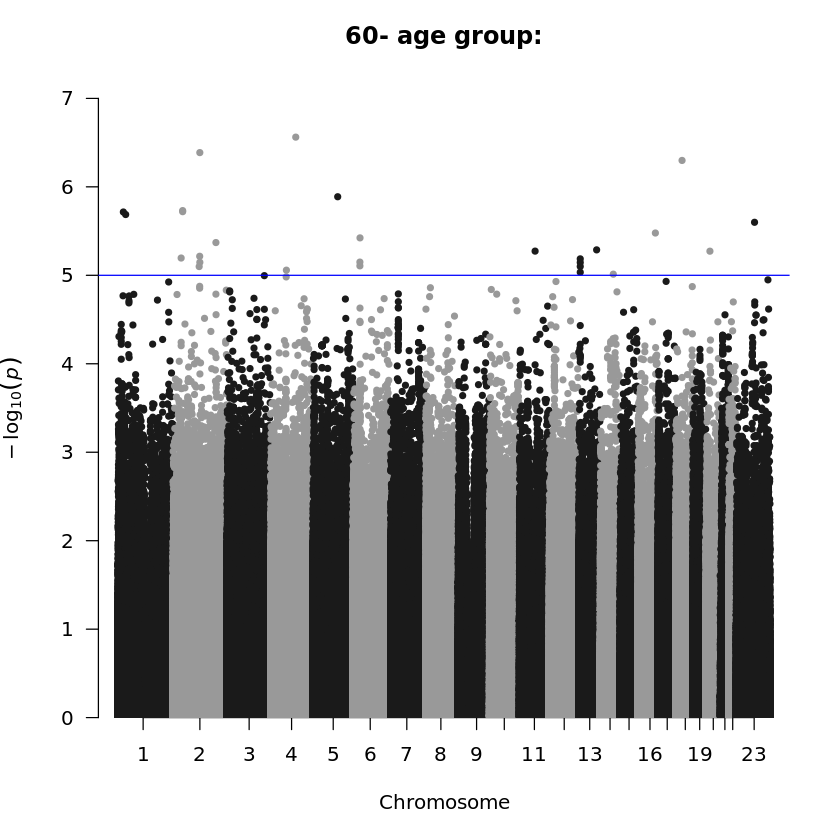

In [39]:
# 60- group
manhattan(age60minus_qc[!is.na(age60minus_qc$P),], chr="CHROM", bp="GENPOS", p="P", snp="ID", main='60- age group:\n')

In [9]:
## save temporary filies
write.table(age60plus_qc, 'temp_age60plus_fgQC.txt', sep=" ", quote=F, row.names = F)
write.table(age60minus_qc, 'temp_age60minus_fgQC.txt', sep=" ", quote=F, row.names = F)

In [ ]:
#dx upload age60minus_hg38_final.txt --dest vasilis/data/GWAS/sensitivity/age_stratified/step2/hg38/